<a href="https://colab.research.google.com/github/spinillac11/DeepLearning/blob/main/DL2A_u_net_segmentation_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torchvision.transforms as transforms
import pickle
import gzip
from tabulate import tabulate


**Image segmentation** is an important task in  computer vision. The goal is to find multiple areas in an image and to assign labels to these area.  It provides a different kind of information than:
- **image classification**  which caracterizes images with global labels;
- **object detection** which usually relies on finding bounding-boxes around  detected objects.

Segmentation is useful and can be used in real-world applications such as medical imaging, microfluidic, flooding maps, self-driving cars, etc. There are two types of image segmentation:
- Semantic segmentation: classify each pixel with a label.
- Instance segmentation: classify each pixel and differentiate each object instance (if there are many instances of the same kind of objects).

U-Net is a semantic segmentation technique [originally proposed for medical imaging segmentation](https://arxiv.org/abs/1505.04597). It’s one of the earlier deep learning segmentation models. This architecture is still widely used in more advanced models like Generative Adversarial or Diffusion Network.

The model architecture is fairly simple: an encoder (for downsampling), a bottleneck,  and a decoder (for upsampling) with skip connections. The encoder extracts global and high level features and the decoder use them to segment the image at the pixel level. This is the meaning of "U": from pixel to abstrac representation, and back to pixels.

U-Net is only based on convolutions. More specifically, the output classification is done at the pixel level with a *(1,1)* convolution. It has therefore  the following advantages:
- parameter and data efficiency,
- independent of the input size.

The following image is taken from the original paper:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"  width="60%" height="30%">


The goal of this lab session is to develop the U-Net architecture for image semantic segmentation and we will consider a binary segmentation task.  

#  Cell nuclei segmentation: the dataset

Cell nuclei segmentation is an essential step in the biological analysis of microscopy images.
This segmentation can be manually achieved with dedicated software, however it is very costly.
In this lab session, the starting point is this [nature paper](https://www.nature.com/articles/s41597-020-00608-w). To quote some part of the paper:

Fully-automated nuclear image segmentation is the prerequisite to ensure statistically significant, quantitative analyses of tissue preparations,applied in digital pathology or quantitative microscopy. The design of segmentation methods that work independently of the tissue type or preparation is complex, due to variations in nuclear morphology, staining intensity, cell density and nuclei aggregations. Machine learning-based segmentation methods can overcome these challenges, however high quality expert-annotated images are required for training. Currently, the limited number of annotated fluorescence image datasets publicly available do not cover a broad range of tissues and preparations. We present a comprehensive, annotated dataset including tightly aggregated nuclei of multiple tissues for the training of machine learning-based nuclear segmentation algorithms. The proposed dataset covers sample preparation methods frequently used in quantitative immunofluorescence microscopy.

To spare some preprocessing time, this lab session starts with this pickle (download it and make it available for your notebook).

In [ ]:
import gdown
datafilen = "nuclei_cells_segmentations.pck"
url = 'https://drive.google.com/uc?id=1U8NbyspyUoZ2rYzPzcB_IS_fht2P1HXS'
gdown.download(url, datafilen, quiet=False)

# Or to download the file with wget:
# ! wget -nc --no-check-certificate "https://drive.usercontent.google.com/download?id=1U8NbyspyUoZ2rYzPzcB_IS_fht2P1HXS&confirm=t" -O "./nuclei_cells_segmentations.pck"


Downloading...
From: https://drive.google.com/uc?id=1U8NbyspyUoZ2rYzPzcB_IS_fht2P1HXS
To: /content/nuclei_cells_segmentations.pck
100%|██████████| 10.4M/10.4M [00:00<00:00, 230MB/s]


'nuclei_cells_segmentations.pck'

In [ ]:
f = open(datafilen, 'rb')
X, Y = pickle.load(f)
print(X.shape, Y.shape)
N = X.shape[0]

torch.Size([79, 1, 128, 128]) torch.Size([79, 1, 128, 128])


Original image / Binary segmentation


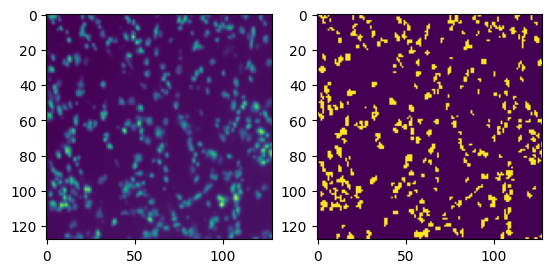

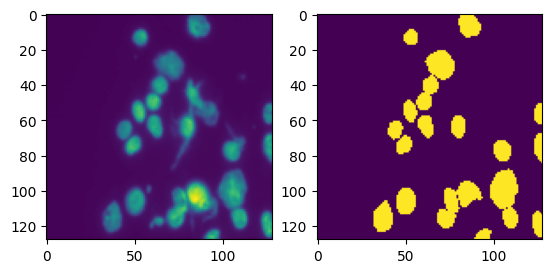

In [ ]:
print("Original image / Binary segmentation")
for i in (3,14): # two random training examples
    figs, axs = plt.subplots(1,2)
    axs[0].imshow(X[i].squeeze()) # original image
    axs[1].imshow(Y[i].squeeze()) # pixel classification

The left pictures represent the input images, while one the right we have the segmentation we want to predict. Therefore input and output have the same dimensions, and the same number of "values": for the input this is the pixel value, for the output it is the class value for each pixel. With the latter, we know for each input pixel in which class it belongs, or if it is in a nucleus or not.  


This pickle contains a modified version of the dataset:
- the same amount of images
- all the images are resized to 128,128
- the segmentation task is converted in a binary pixel classification: nuclei or not.

The goal is now to train a U-Net on this dataset (70 images for training and 9 for "test").

# U-Net overview

Following the previous picture of U-Net, the network is composed of 3 parts: encoder, bottleneck, decoder. These three steps rely on the same building block: the **convolutional block** (convolution, relu, batchnorm, convolution, relu, batchnorm).

The first step is the **encoder**. The goal is to compress the  "geometrical" information with local features (output channels). The encoder first applies a convolution of kernel size (3,3) to extract $F$ features (typically $F=64$ but it is a variable of the architecture). Then the spatial information is compressed using max-pooling (factor 2). The next step does the same:  extract $2\times F$ features from the $F$ first ones, then compression with max-pooling. This operation is repeated 4 times in total to get at the end $F\times 8$ channels that represent global features extracted from the input image.

The **bottleneck** layer is a convolutional block which doubles the number of channels. The idea is to create a "dense" representation of the image to gather both global and local features.

The **decoder** part is similar to the encoder part but "reversed". While we used max-pooling for downsampling in the encoder, the upsampling operation consists in **transposed convolution**. The goal is to increase (so upsample) the spatial dimensions of intermediate features while reducing the number of channels.

The last peculiarity is the **output layer for classification** at the pixel level. In U-Net this last layer relies (once again) on convolution. This means that with the last hidden layer, we recover the same spatial dimension as the input with $F$ feature maps. The classification is carried out for each pixel independently, but the decision is based on $F$ features that encode global information. The classification is done with a convolution with a kernel size of 1, with $F$ input channel and one output channel (the binary classification).

Before creating a U-Net model, we first study the new kind of layer `ConvTranspose2D`

# ConvTranspose2D

In pytorch, transposed convolution is achieved with the module `ConvTranspose2D` (for images or 2D objects).
To better understand how it works, it can be useful to play with it.


Since we will print many matrices to better understand this new operation, we first provide a helper function to better visualize the content of a torch tensor:

In [ ]:
def ppmatrix(m, message=None):
    """Pretty print for matrices
    Args:
    - expect a torch Tensor

    Output:
    The print

    Apply detach, squeeze, and numpy to the input tensor (not inplace)
    """
    if message is not None:
        print(message)
    if len(m.shape) == 1:
        print(m.squeeze().detach().numpy())
    else:
        print(tabulate(m.squeeze().detach().numpy(),tablefmt="fancy_grid",floatfmt=".3f"))


Now we can use it to see what are the parameters of `ConvTranspose2D`:

In [ ]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=True)
ppmatrix(c.weight,"weights: ")
print("the bias: ")
ppmatrix(c.bias)

weights: 
╒═══════╤════════╕
│ 0.474 │ -0.051 │
├───────┼────────┤
│ 0.017 │ -0.075 │
╘═══════╧════════╛
the bias: 
0.38470107


As you can see, the operation is parametrized by a convolution mask $\mathbf{W}$ and one bias term. For one value $v$ in the input, we get as output $v\times\mathbf{W}+b$. As an illustration, we can consider a simple image with one channel. To start, it is easier to start without the bias term:


In [ ]:
im = th.zeros(1,1,2,2)
c = nn.ConvTranspose2d(in_channels=1, out_channels=1,
                       kernel_size=2, stride=1,
                       bias=False)
print("Weights: ",c.weight)
print("Bias: ",c.bias)

for i in range(4):
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    print("-------------------")
    ppmatrix(im,"image: ")
    ppmatrix(c(im),"output: ")


Weights:  Parameter containing:
tensor([[[[ 0.0629,  0.3015],
          [-0.1040, -0.4721]]]], requires_grad=True)
Bias:  None
-------------------
image: 
╒═══════╤═══════╕
│ 1.000 │ 0.000 │
├───────┼───────┤
│ 0.000 │ 0.000 │
╘═══════╧═══════╛
output: 
╒════════╤════════╤═══════╕
│  0.063 │  0.302 │ 0.000 │
├────────┼────────┼───────┤
│ -0.104 │ -0.472 │ 0.000 │
├────────┼────────┼───────┤
│  0.000 │  0.000 │ 0.000 │
╘════════╧════════╧═══════╛
-------------------
image: 
╒═══════╤═══════╕
│ 0.000 │ 0.000 │
├───────┼───────┤
│ 1.000 │ 0.000 │
╘═══════╧═══════╛
output: 
╒════════╤════════╤═══════╕
│  0.000 │  0.000 │ 0.000 │
├────────┼────────┼───────┤
│  0.063 │  0.302 │ 0.000 │
├────────┼────────┼───────┤
│ -0.104 │ -0.472 │ 0.000 │
╘════════╧════════╧═══════╛
-------------------
image: 
╒═══════╤═══════╕
│ 0.000 │ 1.000 │
├───────┼───────┤
│ 0.000 │ 0.000 │
╘═══════╧═══════╛
output: 
╒═══════╤════════╤════════╕
│ 0.000 │  0.063 │  0.302 │
├───────┼────────┼────────┤
│ 0.000 │ -0.104

Try now with an image full of 1 and explain the result:

In [ ]:
im = th.ones(1,1,2,2)
ppmatrix(c(im))


╒════════╤════════╤════════╕
│  0.063 │  0.364 │  0.302 │
├────────┼────────┼────────┤
│ -0.041 │ -0.212 │ -0.171 │
├────────┼────────┼────────┤
│ -0.104 │ -0.576 │ -0.472 │
╘════════╧════════╧════════╛


Understand each value in the output image, especially the one in the center.  

Now we can consider different stride:

In [ ]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1,
                       kernel_size=2, stride=2,
                       bias=False)
print(c.weight)
for i in range(4):
    print("----------------")
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    ppmatrix(im,"image:")
    print(c(im),"output:")

Parameter containing:
tensor([[[[-0.4456, -0.3398],
          [-0.1372, -0.2478]]]], requires_grad=True)
----------------
image:
╒═══════╤═══════╕
│ 1.000 │ 0.000 │
├───────┼───────┤
│ 0.000 │ 0.000 │
╘═══════╧═══════╛
tensor([[[[-0.4456, -0.3398,  0.0000,  0.0000],
          [-0.1372, -0.2478,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>) output:
----------------
image:
╒═══════╤═══════╕
│ 0.000 │ 0.000 │
├───────┼───────┤
│ 1.000 │ 0.000 │
╘═══════╧═══════╛
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [-0.4456, -0.3398,  0.0000,  0.0000],
          [-0.1372, -0.2478,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>) output:
----------------
image:
╒═══════╤═══════╕
│ 0.000 │ 1.000 │
├───────┼───────┤
│ 0.000 │ 0.000 │
╘═══════╧═══════╛
tensor([[[[ 0.0000,  0.0000, -0.4456, -0.3398],
          [ 0.0000,  

Try to understand the previous and the next examples and how it can be used to upsample.

In [ ]:
im = th.ones(1,1,2,2)
ppmatrix(c(im))

╒════════╤════════╤════════╤════════╕
│ -0.446 │ -0.340 │ -0.446 │ -0.340 │
├────────┼────────┼────────┼────────┤
│ -0.137 │ -0.248 │ -0.137 │ -0.248 │
├────────┼────────┼────────┼────────┤
│ -0.446 │ -0.340 │ -0.446 │ -0.340 │
├────────┼────────┼────────┼────────┤
│ -0.137 │ -0.248 │ -0.137 │ -0.248 │
╘════════╧════════╧════════╧════════╛


More details can be found on this [blog post](https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967).

# Simple U-Net
Now the goal is to implement a simplified version of U-Net (a shorter version of the "U").
The first step is the **encoder** that compresses (or reduces) the spatial dimension to create rich features that represent global information.

## Step by step
The encoder is composed of many successive blocks. One block is made of :
- a convolution (kernel size 3, stride 1), relu, batchnorm
- a convolution (kernel size 3, stride 1), relu, batchnorm
- followed by a max-pooling that reduces the dimensions by 2 (each spatial dimension is halved)

The input image has one input channel and the first convolution block generates $F$ output channels. The next convolution blocks have a number of output channel which is twice the number of input channel. $F$ will be a parameter and we start with $F=4$.

Since we will need many times to instantiate the same kind of blocks to build the encoder, the bottleneck and the decoder, we can write a function like this:  

In [ ]:
def make_conv_block(in_c,out_c,
                    kernel_size=3,
                    stride=1,
                    padding=1):
    """ Convolutional block:
        A basic block for U-Net. Twice the sequence
        - 3x3 convolutions (stride 1, padding = 1)
        - relu + BatchNorm
        It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
    """
    mod = nn.Sequential(
                nn.Conv2d(in_c, out_c,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding
                    ),
                nn.ReLU(),
                nn.BatchNorm2d(out_c),
                nn.Conv2d(out_c, out_c,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding
                    ),
                nn.ReLU(),
                nn.BatchNorm2d(out_c),
                )
    return mod

One block generatated by this function.  

In [ ]:
# TODO
model = make_conv_block(1, 4)
print(model)

Y_pred = model(X)
print(Y_pred.shape)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([79, 4, 128, 128])


Now write a class for the encoder that uses this function.

In [ ]:
class Encoder(nn.Module):

    def __init__(self, base_channels = 4, kernel_size = 3, stride = 1, padding = 1):
        super(Encoder, self).__init__()
        self.block1 = make_conv_block(1, base_channels, kernel_size, stride, padding)
        self.block2 = make_conv_block(base_channels, 2*base_channels, kernel_size, stride, padding)
        self.block3 = make_conv_block(2*base_channels, 4*base_channels, kernel_size, stride, padding)
        self.block4 = make_conv_block(4*base_channels, 8*base_channels, kernel_size, stride, padding)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Reduces the size of the rows and columns by half

    def forward(self, x):
        self.outblock1 = self.block1(x)
        x = self.maxpool(self.outblock1)
        self.outblock2 = self.block2(x)
        x = self.maxpool(self.outblock2)
        self.outblock3 = self.block3(x)
        x = self.maxpool(self.outblock3)
        self.outblock4 = self.block4(x)
        x = self.maxpool(self.outblock4)

        return x

model = Encoder()
pred_coder = model.forward(X)
print(pred_coder.shape)

torch.Size([79, 32, 8, 8])


The **bottleneck** layer is a convolutional layer which doubles the number of channels. The idea is to create a "dense" representation of the image to gather both global and local features.

**TODO**: write the corresponding module and test if it works properly. Check the output dimensions.

In [ ]:
def make_bottleneck(in_c,
                    kernel_size=3,
                    stride=1,
                    padding=1):
  modbn = make_conv_block(in_c, in_c*2,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding)
  return modbn

model = Encoder()
pred_coder = model.forward(X)
print(pred_coder.shape)
model_bn = make_bottleneck(pred_coder.shape[1])
predbn = model_bn(pred_coder)
print(predbn.shape)

torch.Size([79, 32, 8, 8])
torch.Size([79, 64, 8, 8])


The **decoder** part is similar to the encoder part but reversed. While we used max-pooling for downsampling in the encoder, the upsampling operation consists in **transposed convolution**. The goal is to increase (so upsample) the spatial dimensions of intermediate feature maps while reducing the number of channels by a factor 2 for all of them. The important point is the residual connection. In U-Net, the residual connection is not a simple addition but a concatenation.

**TODO**: write the corresponding module and test if it works properly. Check the output dimensions.

In [ ]:
class Decoder(nn.Module):

    def __init__(self, base_channels=4, kernel_size=3, stride=1, padding=1):
        super(Decoder, self).__init__()

        self.up4 = nn.ConvTranspose2d(16*base_channels, 8*base_channels, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(8*base_channels, 4*base_channels, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(4*base_channels, 2*base_channels, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(2*base_channels, base_channels, kernel_size=2, stride=2)

        self.dec_block4 = make_conv_block(16*base_channels,8*base_channels, kernel_size, stride, padding)
        self.dec_block3 = make_conv_block(8*base_channels, 4*base_channels, kernel_size, stride, padding)
        self.dec_block2 = make_conv_block(4*base_channels, 2*base_channels, kernel_size, stride, padding)
        self.dec_block1 = make_conv_block(2*base_channels, base_channels, kernel_size, stride, padding)

    def forward(self, x, encoder):

        x = self.up4(x)
        x = th.cat((x, encoder.outblock4), dim=1)
        self.outdec4 = self.dec_block4(x)

        x = self.up3(self.outdec4)
        x = th.cat((x, encoder.outblock3), dim=1)
        self.outdec3 = self.dec_block3(x)

        x = self.up2(self.outdec3)
        x = th.cat((x, encoder.outblock2), dim=1)
        self.outdec2 = self.dec_block2(x)

        x = self.up1(self.outdec2)
        x = th.cat((x, encoder.outblock1), dim=1)
        self.outdec1 = self.dec_block1(x)

        return self.outdec1

print("Original data set: ", X.shape)
model = Encoder()
pred_coder = model.forward(X)
print("Dataset Encoded: ", pred_coder.shape)
model_bn = make_bottleneck(pred_coder.shape[1])
predbn = model_bn(pred_coder)
print("Dataset after bottleneck: ", predbn.shape)
model_decoder = Decoder()
pred_decoder = model_decoder.forward(predbn, model)
print("Dataset after decoder: ", pred_decoder.shape)

Original data set:  torch.Size([79, 1, 128, 128])
Dataset Encoded:  torch.Size([79, 32, 8, 8])
Dataset after bottleneck:  torch.Size([79, 64, 8, 8])
Dataset after decoder:  torch.Size([79, 4, 128, 128])


The last peculiarity is the output layer for classification at the pixel level. In U-Net this last layer is (once again) a convolutional layer. This means that with the last hidden layer, we recover the same spatial dimension as the input with $F$ feature maps. The classification is carried out for each pixel independently, but the decision is based on $F$ features that encode global information.

**TODO**: write the corresponding module and test if it works properly. Check the output dimensions.

In [ ]:
def make_last_conv(in_c, num_classes=2,
                    kernel_size=1,
                    stride=1):
    return nn.Conv2d(in_c, num_classes, kernel_size=kernel_size, stride=stride)

print(pred_decoder.shape[1])
model_last = make_last_conv(pred_decoder.shape[1])
pred_last = model_last(pred_decoder)
print(pred_last.shape)


4
torch.Size([79, 2, 128, 128])


## A class for  simple U-Net

Now we can merge all we did in the previous section to create a U-Net model (light version).

**TODO**:
- Write the `Module` that takes $F$ as hyper-parameter
- Train it on the first 70 training images with $F=4$


In [ ]:
class Unet(nn.Module):
    def __init__(self, F=4, kernel_size=3, stride=1, padding=1):
        super(Unet, self).__init__()

        self.encoder = Encoder(base_channels=F)
        self.bottleneck = make_bottleneck(F*8)
        self.decoder = Decoder(base_channels=F)
        self.last_conv = make_last_conv(F)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, self.encoder)
        x = self.last_conv(x)
        return x

print(X.shape)
model = Unet()
pred = model.forward(X)
print(pred.shape)

torch.Size([79, 1, 128, 128])
torch.Size([79, 2, 128, 128])


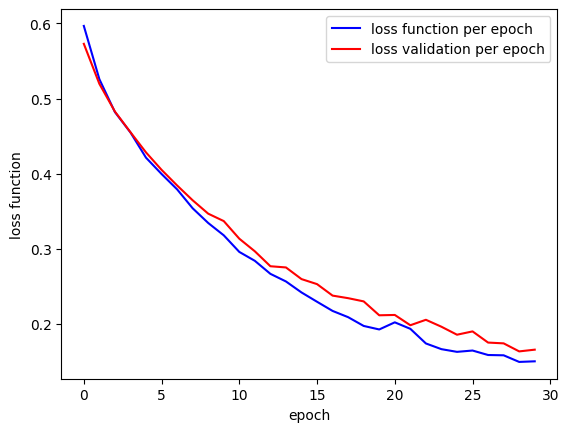

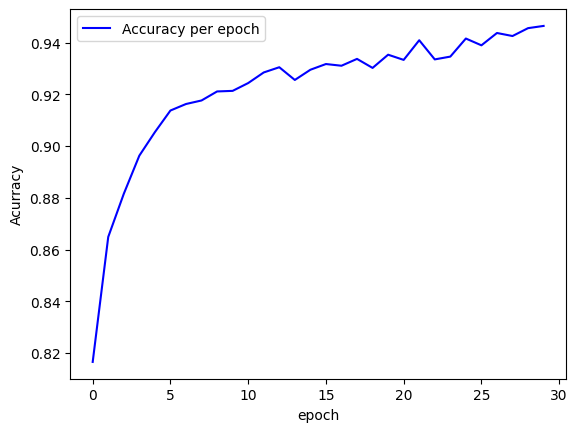

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

## -----------> Training function <----------------
def training (Trainloader, Validloader, model, loss_fn, optimizer, Nepochs):
  training_loss_rec = []
  val_loss_rec = []
  accuracy_rec = []

  ## -----------> generic training loop <----------------
  for epoch in range(Nepochs):
    ## ------- training ------
    batch_training_loss = 0.0
    n_batches = 0

    for X, Y in Trainloader:
      optimizer.zero_grad()
      Y_target = Y.squeeze(1).long()
      Y_pred = model.forward(X)
      training_loss = loss_fn(Y_pred,Y_target)
      training_loss.backward()
      optimizer.step()

      batch_training_loss += training_loss.item()
      n_batches += 1

    epoch_training_loss = batch_training_loss / n_batches # average loss
    training_loss_rec.append(epoch_training_loss)

    ## ------- validation ------
    bacth_val_loss = 0.0
    val_batches = 0
    correct = 0
    total = 0

    with th.no_grad():
      for Xv, Yv in Validloader:
        Yv_target = Yv.squeeze(1).long()
        Y_pred_v = model.forward(Xv)
        val_loss = loss_fn(Y_pred_v, Yv_target)

        bacth_val_loss += val_loss.item()
        val_batches += 1

        preds = th.argmax(Y_pred_v, dim=1)
        correct += (preds == Yv_target).sum().item()
        total += Yv_target.numel()

      epoch_val_loss = bacth_val_loss / val_batches
      val_loss_rec.append(epoch_val_loss)

      if total > 0:
        epoch_val_acc = correct / total
      else:
        epoch_val_acc = 0.0

      accuracy_rec.append(epoch_val_acc)

  return training_loss_rec, val_loss_rec, accuracy_rec

## -----------> Data set <----------------
N = X.shape[0]
N_train = 70
N_valid = N - N_train

X_train = X[:N_train]
Y_train = Y[:N_train]
X_valid = X[N_train:]
Y_valid = Y[N_train:]

Trainset = TensorDataset(X_train, Y_train)
Validset = TensorDataset(X_valid, Y_valid)

BATCH_SIZE = 8

Trainloader = DataLoader(Trainset, batch_size=BATCH_SIZE, shuffle=True)
Validloader = DataLoader(Validset, batch_size=BATCH_SIZE, shuffle=False)

## -----------> Training <----------------
model = Unet()

loss_fn = nn.CrossEntropyLoss() #Do not require activation nn.LogSoftmax()

Lr = 1e-3
optimizer = th.optim.Adam(model.parameters(), lr=Lr)

NEPOCHS = 30

training_loss, val_loss, val_accuracy = training(Trainloader, Validloader, model, loss_fn, optimizer, NEPOCHS)

## -----------> Plot results <----------------
plt.plot(training_loss, 'b', label = "loss function per epoch")
plt.plot(val_loss, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

plt.plot(val_accuracy, 'b', label = "Accuracy per epoch")
plt.xlabel('epoch')
plt.ylabel('Acurracy')
plt.legend()
plt.show()

# Evaluation

The evalution is important to really assess what we achieved and it can depend on the task and our purpose.

Of course we can compute the accuracy (the % of well classified pixels), but it could be not enough. Here we can also plot the evaluation.

**TODO**:
- make a function that plots the evaluation result of an input image
- try it on all the test images
- maybe you can look at the accurate part, but what if you want to see which pixels belonging to a nucleous is missed ?
- and for pixels wrongly affected to the nucleous class ?

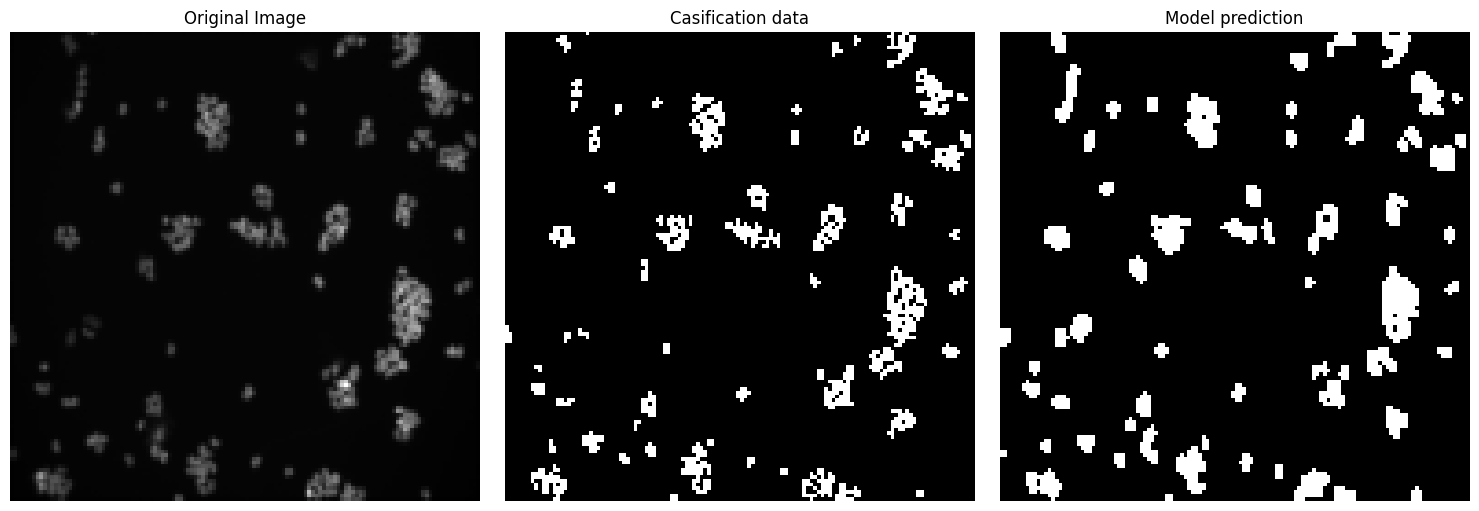

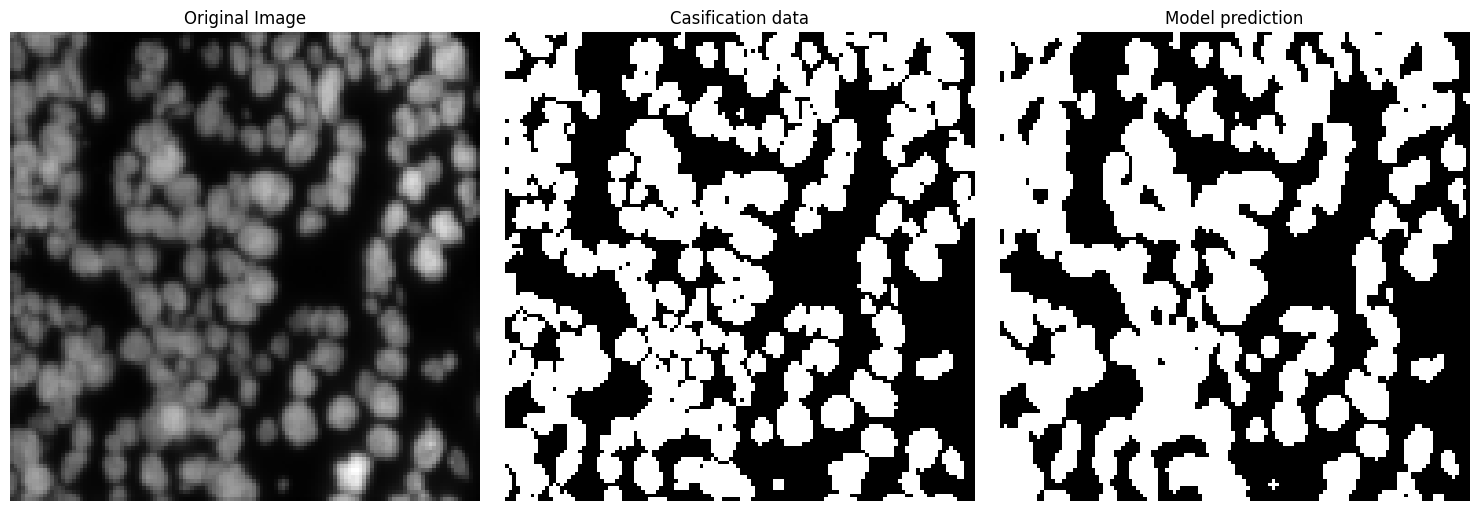

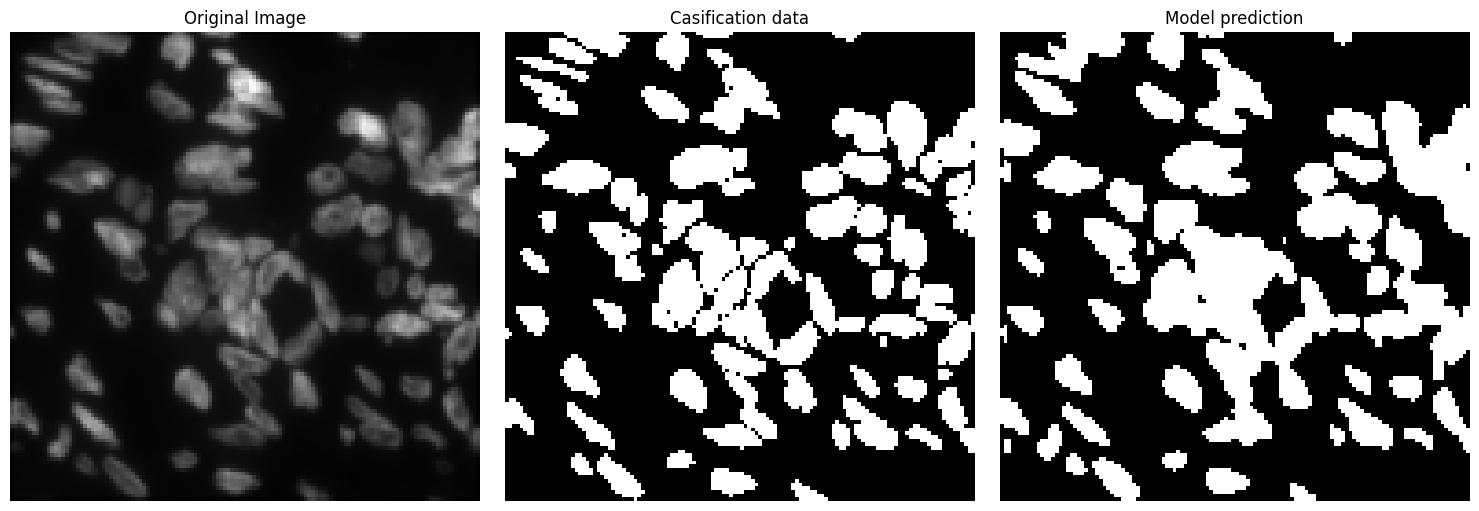

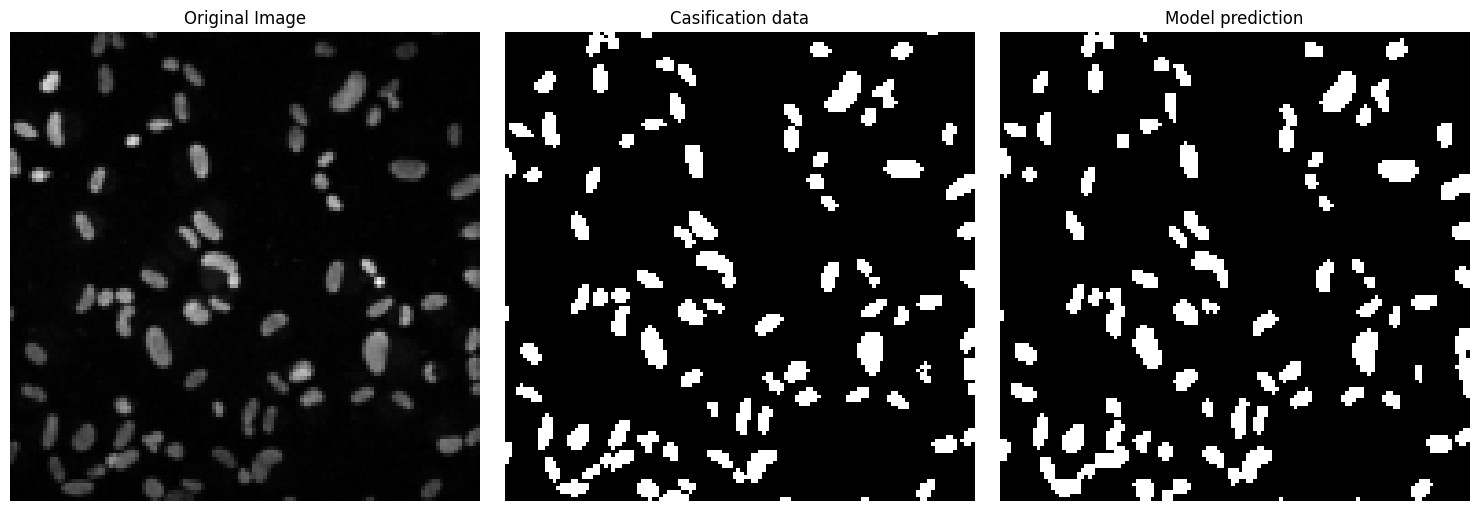

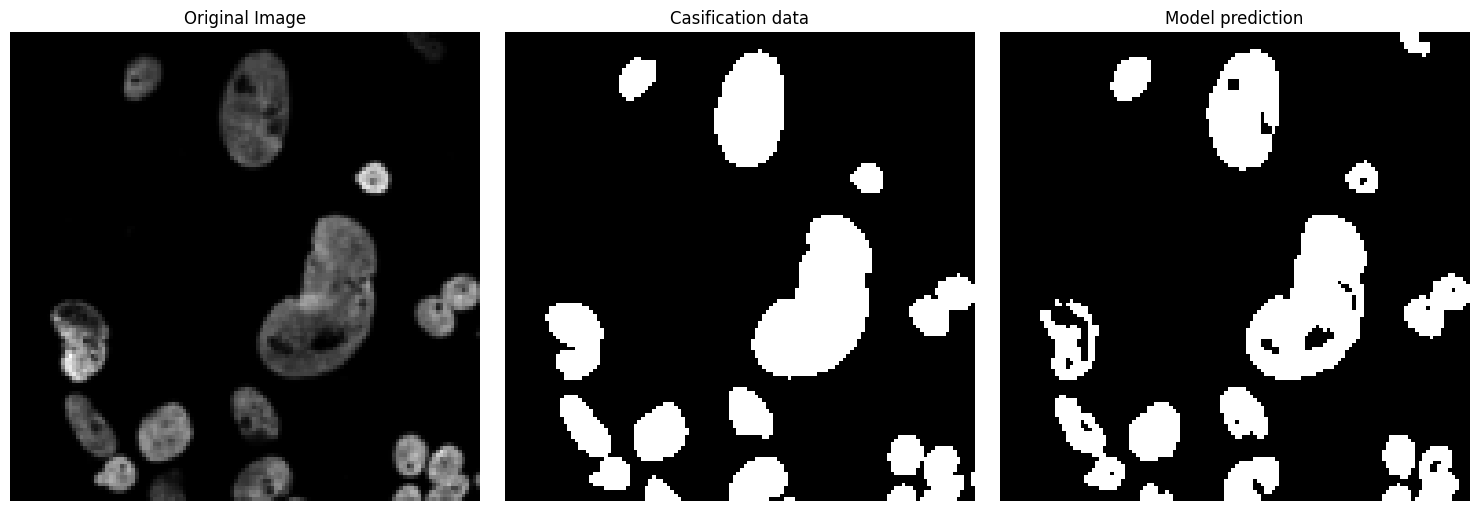

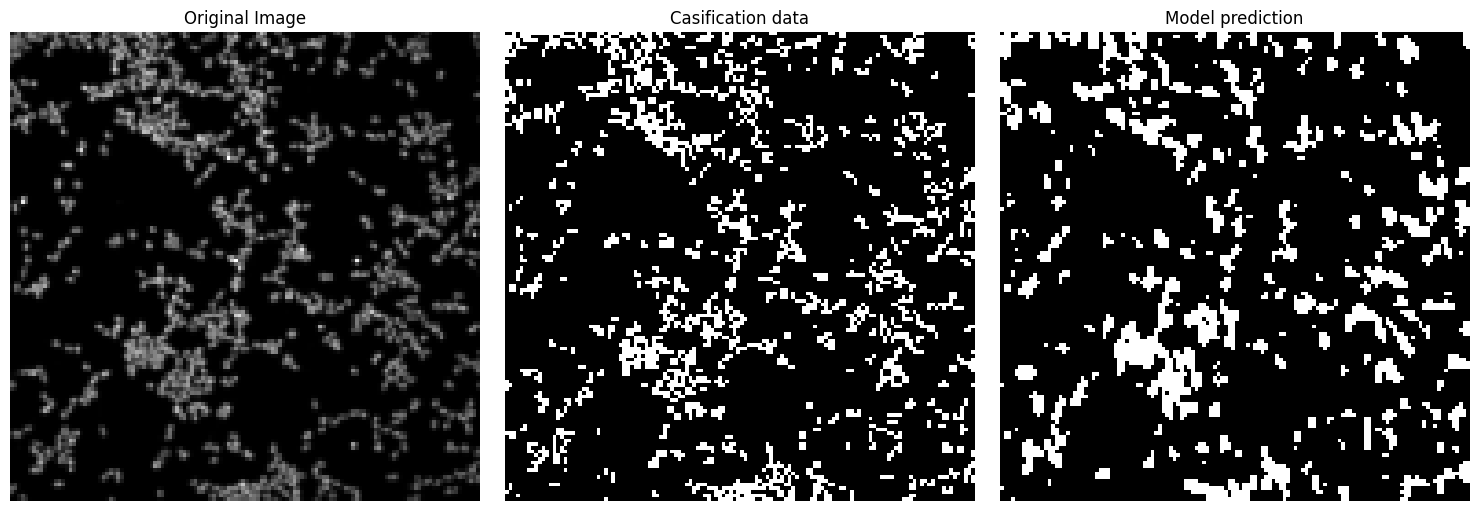

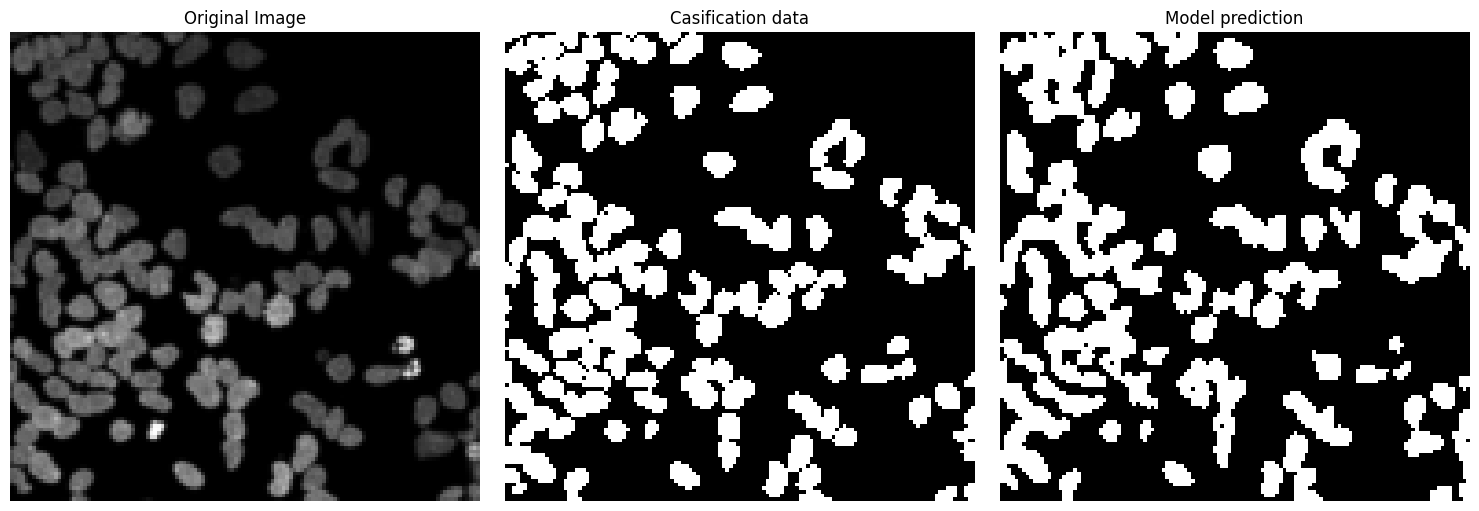

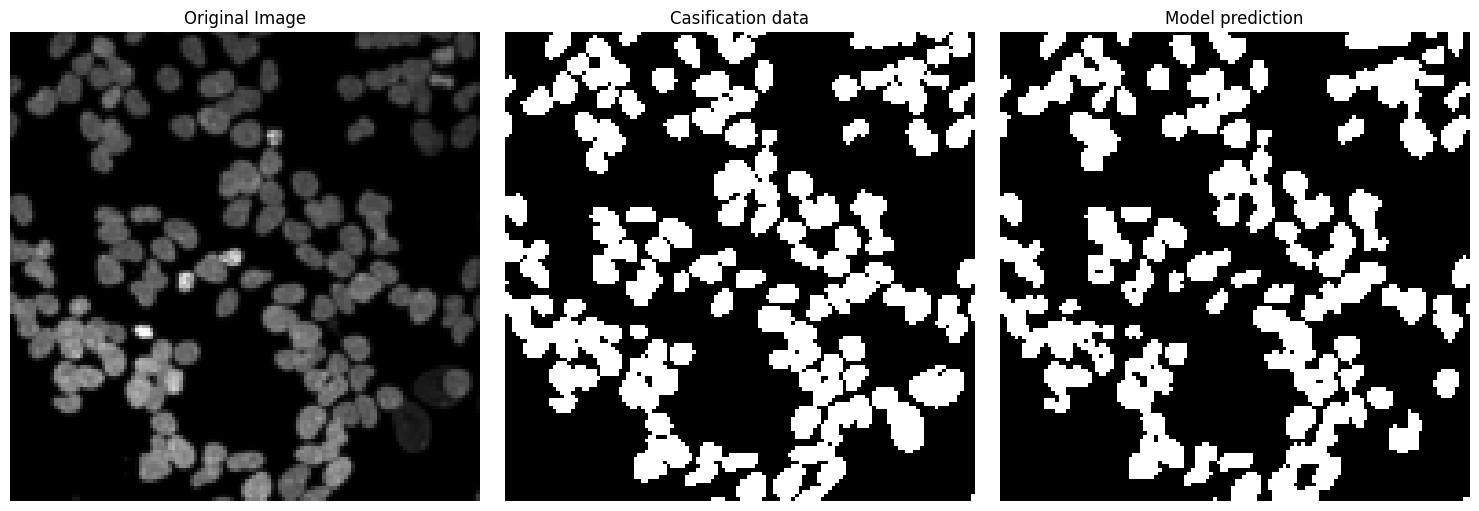

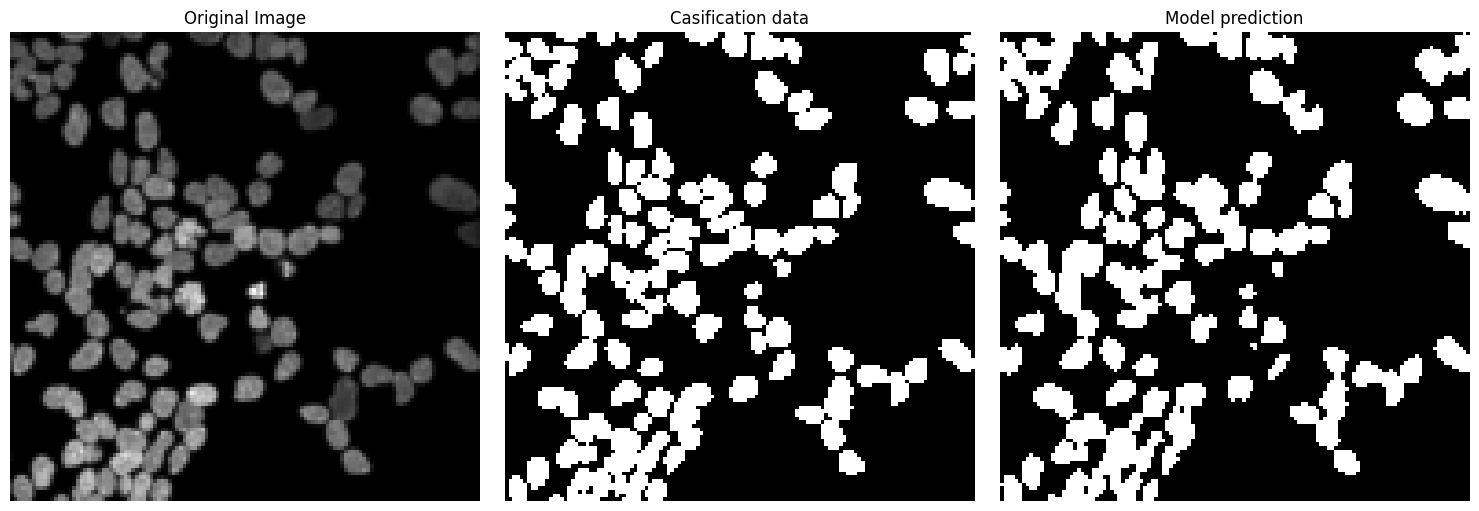

In [ ]:
def evaluation(image, target, prediction):

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  titles = ['Original Image', 'Casification data', 'Model prediction']

  axes[0].imshow(image.squeeze(), cmap='gray')
  axes[1].imshow(target.squeeze(), cmap='gray')
  axes[2].imshow(prediction.squeeze(), cmap='gray')

  for ax, title in zip(axes, titles):
      ax.set_title(title)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

with th.no_grad():
    for Xv, Yv in Validloader:

      Y_pred_v = model.forward(Xv)
      prediction = th.argmax(Y_pred_v, dim=1)
      Y_target = Yv.squeeze(1).long()

      for i in range(Xv.shape[0]):
        img_input = Xv[i].squeeze(0)

        evaluation(image=img_input, target=Y_target[i], prediction=prediction[i])

## Precision and recall

For segmentation, it can be meaningful to look at the precision and recall. These two terms have very broad meaning depending on the purpose. Here we could say :
- The precision for the class 1 (a nucleus) is the ratio between the number of true positives for the class 1  and the total of pixels classified as nuclei by the model.
- The recall is the ratio between the number of pixels of class 1 correctly classified and the total of pixels classified that should be classified as nuclei.

These measures depend on a threshold of the output score. While the "natural" threshold is $0$ on the output score (or $0.5$ if the model outputs probabilities), we can consider different tradeoff between precision and recall by varying the threshold.

**TODO:**
- Make a function which computes precision and recall for a given threshold
- Plot the precision *vs* recall curve for a threshold varying between -5 and +5
- Compare models with $F=4,16,32$


In [ ]:
def precision_recall(class_pred, targets, threshold):
  scores_class1 = class_pred[:, 1, :, :]
  predictions = (scores_class1 > threshold).long()
  targets_class1 = (targets == 1).long()

  TP = (targets_class1 * predictions).sum().item()
  FP = ((1 - targets_class1) * predictions).sum().item()
  FN = (targets_class1 * (1 - predictions)).sum().item()

  if (TP + FP) == 0:
    precision = 0.0
  else:
    precision = TP / (TP + FP)

  if (TP + FN) == 0:
    recall = 0.0
  else:
    recall = TP / (TP + FN)

  return precision, recall



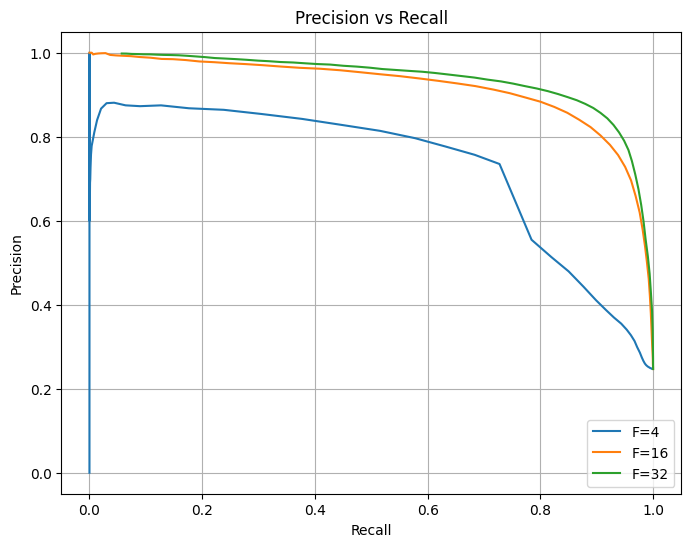

In [ ]:
def plot_pr_curve(model, Validloader, F_value):

    preds = []
    targets = []

    with th.no_grad():
        for Xv, Yv in Validloader:
            Yv_target = Yv.squeeze(1).long()
            pred = model(Xv)

            preds.append(pred)
            targets.append(Yv_target)

    preds = th.cat(preds, dim=0)
    targets = th.cat(targets, dim=0)

    thresholds = np.linspace(-5, 5, 100)

    precision_values = []
    recall_values = []

    for t in thresholds:
        P, R = precision_recall(preds, targets, t)
        precision_values.append(P)
        recall_values.append(R)

    return recall_values, precision_values, f"F={F_value}"


F_values = [4, 16, 32]
results = []

plt.figure(figsize=(8, 6))

NEPOCHS = 10
for F_value in F_values:
    model = Unet(F=F_value)
    optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    # Training with parameter F
    training_loss, val_loss, val_accuracy = training(Trainloader, Validloader, model, loss_fn, optimizer, NEPOCHS)
    # Precision and recall calculation
    recall_vals, precision_vals, label = plot_pr_curve(model, Validloader, F_value)
    plt.plot(recall_vals, precision_vals, label=label)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend()
plt.grid(True)
plt.show()

# U-Net

Now the goal is to implement U-Net. As a proposed roadmap we propose the following step:
- a function to create a convolutional block
- a module for the encoder
- a module for the decoder
- and a U-Net module to wrap everything

The number of feature map ($F=64$ in the original work) must be a variable of the UNet. For the first round of experiment, we can use $F=8$.  


**TODO:**
- run the training on the 70 first images and spare the last 9 for evaluation
- after the training process, look at the results on some training images and the evaluation ones.


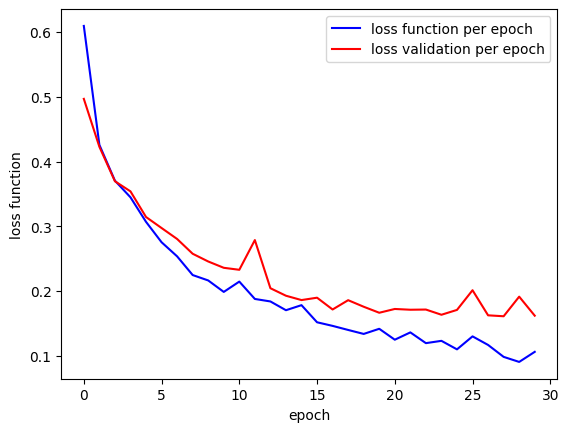

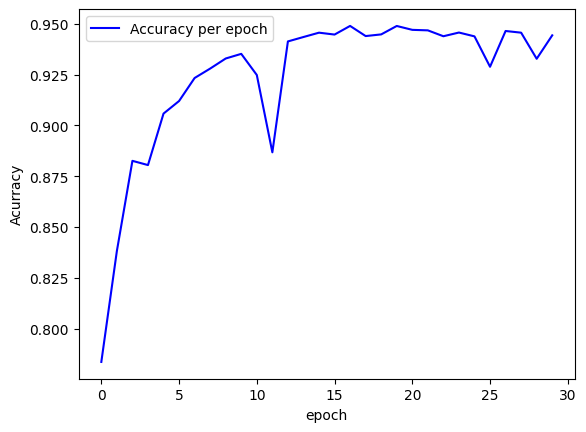

Training examples:


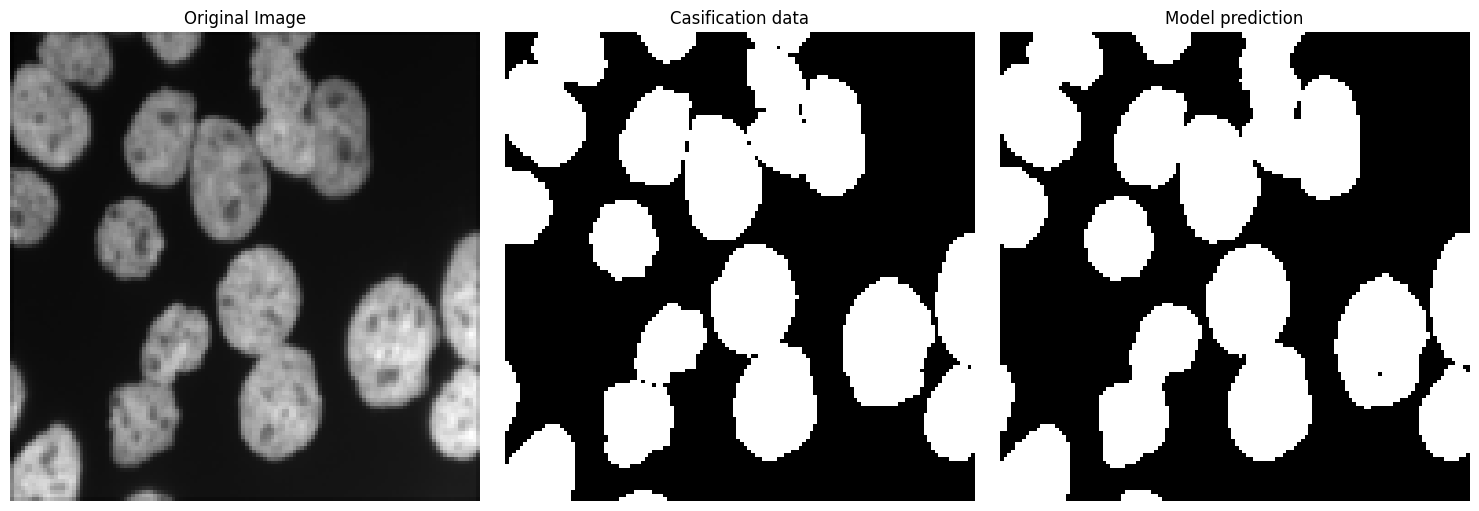

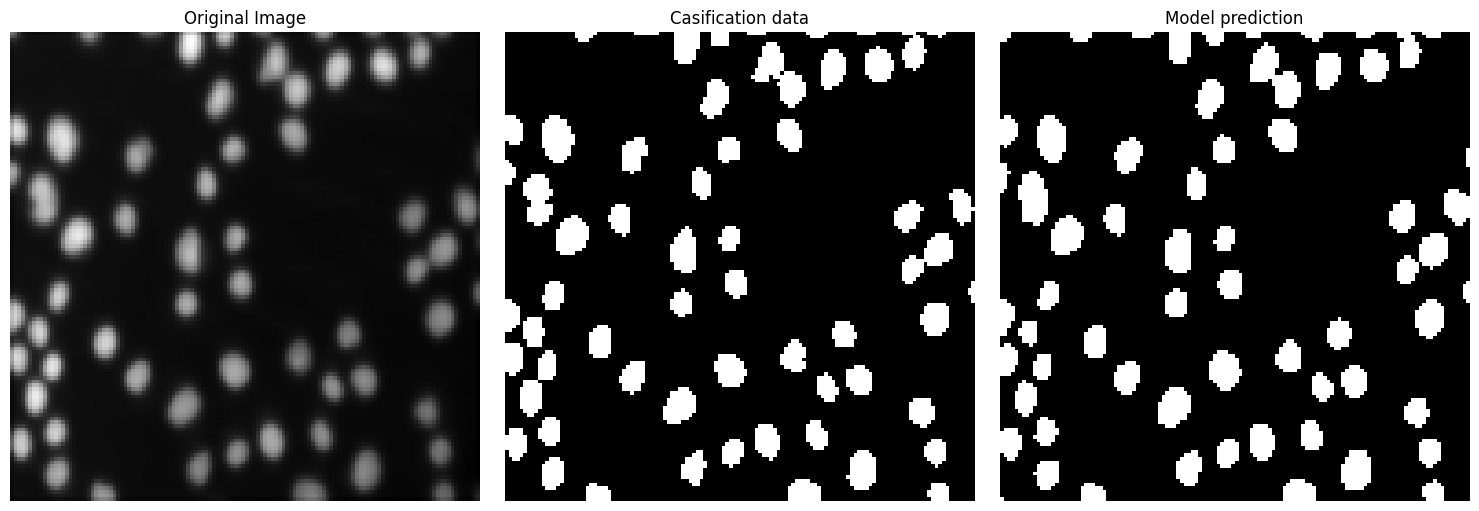

Valid examples:


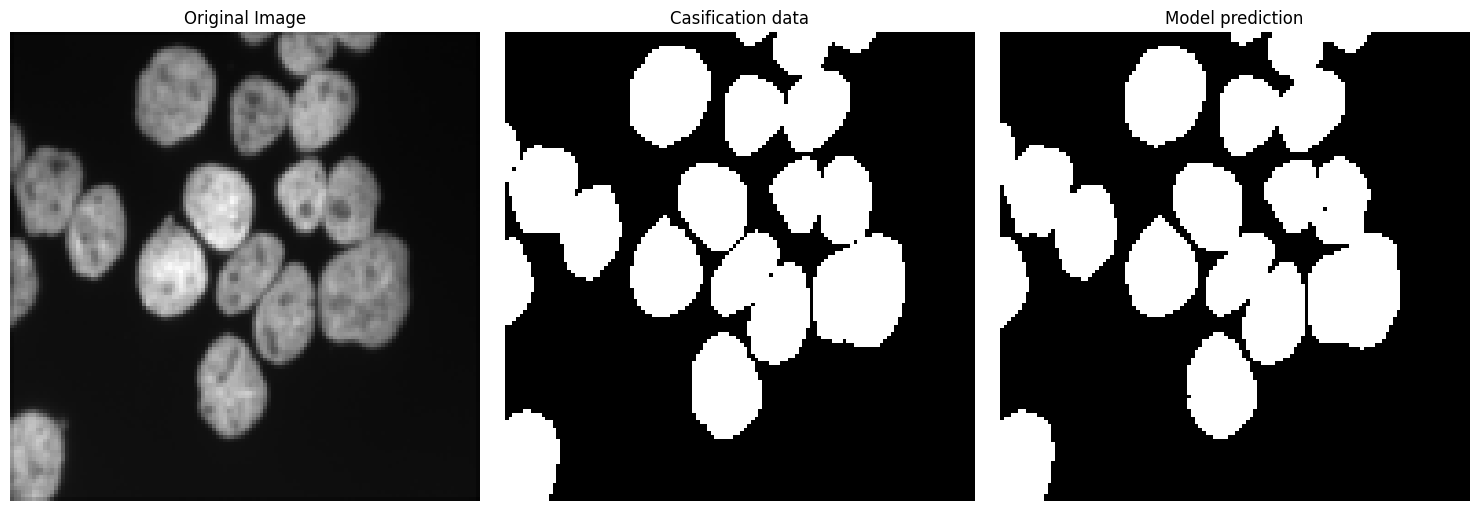

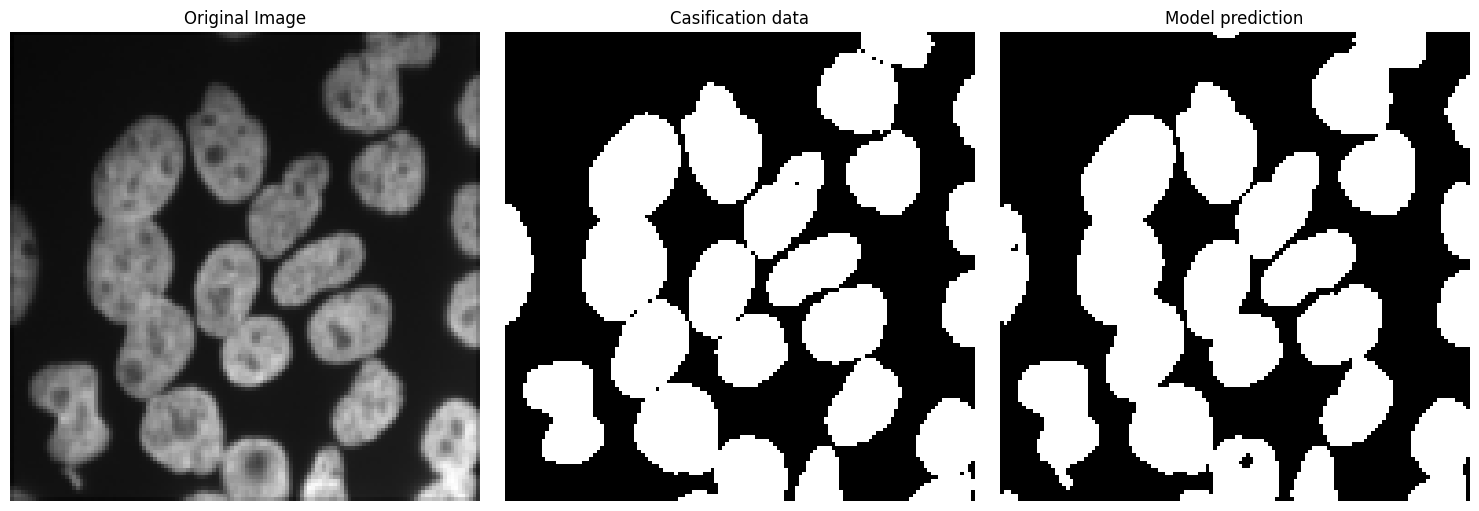

In [ ]:
## -----------> Data set <----------------
N = X.shape[0]
N_train = 70
N_valid = N - N_train

X_train = X[:N_train]
Y_train = Y[:N_train]
X_valid = X[N_train:]
Y_valid = Y[N_train:]

Trainset = TensorDataset(X_train, Y_train)
Validset = TensorDataset(X_valid, Y_valid)

BATCH_SIZE = 8

Trainloader = DataLoader(Trainset, batch_size=BATCH_SIZE, shuffle=True)
Validloader = DataLoader(Validset, batch_size=BATCH_SIZE, shuffle=False)

## -----------> Training <----------------
F = 8 #number of feature map
model = Unet(F=F)

loss_fn = nn.CrossEntropyLoss() #Do not require activation nn.LogSoftmax()

Lr = 1e-3
optimizer = th.optim.Adam(model.parameters(), lr=Lr)

NEPOCHS = 30

training_loss, val_loss, val_accuracy = training(Trainloader, Validloader, model, loss_fn, optimizer, NEPOCHS)

## -----------> Plot results <----------------
plt.plot(training_loss, 'b', label = "loss function per epoch")
plt.plot(val_loss, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

plt.plot(val_accuracy, 'b', label = "Accuracy per epoch")
plt.xlabel('epoch')
plt.ylabel('Acurracy')
plt.legend()
plt.show()

print("Training examples:")
shown = 0
with th.no_grad():
    for X, Y in Trainloader:
        Y_target = Y.squeeze(1).long()
        Y_pred = model(X)
        preds = th.argmax(Y_pred, dim=1)

        batch_size = X.shape[0]
        max_show = min(2, batch_size)

        for i in range(max_show):
            img_input = X[i].squeeze()
            evaluation(img_input, Y_target[i], preds[i])
            shown += 1
        if shown >= 2:
          break

print("Valid examples:")
shown = 0
with th.no_grad():
    for X, Y in Trainloader:
        Y_target = Y.squeeze(1).long()
        Y_pred = model(X)
        preds = th.argmax(Y_pred, dim=1)

        batch_size = X.shape[0]
        max_show = min(2, batch_size)

        for i in range(max_show):
            img_input = X[i].squeeze()
            evaluation(img_input, Y_target[i], preds[i])
            shown += 1
        if shown >= 2:
          break


# Data Augmentation
When the dataset is scarce, we can try data-augmentation. The idea is to apply transformation introduce diversity in the dataset with basic transformation. [Look at this page for more information](https://pytorch.org/vision/main/transforms.html).

**TODO:**
- Select a couple of transformation
- Evaluate the impact of data-augmentation on our task.


